In [1]:
L1="2800.HK"
start='2017-01-01'
end=None

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf 
import talib as TA
from datetime import datetime
from datetime import date
from dateutil.relativedelta import relativedelta
#
from findiff import FinDiff

In [3]:
def peak(df,duration):
    peak1=df.rolling(window=duration).max() 
    return(peak1)

def ohlc_gen(stock_code,from1):
    import yfinance as yf
    import talib as TA
    import matplotlib.dates as mdates
    L=[]
    #Fetch daily stock data 
    data = yf.download(stock_code,from1)
    data["Date"]=data.index
    data["Week"]=data["Date"].dt.week
    data["Year"]=data["Date"].dt.year
    #Create weekly data from daily data
    data_weekly=data[data.index>=from1].groupby(["Year","Week"]).agg(
        {"Date":"first",'Open':'first', 'High':'max', 'Low':'min', 'Close':'last','Volume':'sum'})
    #Add TA in daily and weekly data
    data_weekly["Week"]=data_weekly.index
    data_weekly.index=data_weekly["Date"]
    #
    dayofyear=data['Date'].dt.dayofyear
    data['firstday'] = (dayofyear<dayofyear.shift(1)) | (dayofyear.shift(1).isnull())
    #
    data["EMA9"]=TA.EMA(data["Close"],9)
    data["EMA19"]=TA.EMA(data["Close"],19)
    data["EMA50"]=TA.EMA(data["Close"],50)
    data["RSI9"]=TA.RSI(data["Close"],9)
    data["macd"], data["macdsignal"], data["macdhist"] = TA.MACD(data["Close"], 
                                                           fastperiod=12, 
                                                           slowperiod=26, signalperiod=9)
    #
    data["EMA5"]=TA.EMA(data["Close"],5)
    data["BBupper"], data["BBmid"], data["BBlower"] = TA.BBANDS(data["Close"], 
                                                                timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    data['RSI9-75']=data['RSI9'].rolling(200).apply(lambda x: np.percentile(x, 75))
    data['RSI9-9']=TA.EMA(data["RSI9"],9)
    data['RSI9-19']=TA.EMA(data["RSI9"],19)
    data['RSI9-50']=TA.EMA(data["RSI9"],50)
    data['obv']=TA.OBV(data['Close'], data['Volume'])
    data["obv9"]=TA.EMA(data["obv"],9)
    data["obv19"]=TA.EMA(data["obv"],19)
    data["obv50"]=TA.EMA(data["obv"],50)
    data["peak"]=peak(data["Close"],20)
    data["chaikin"]=TA.ADOSC(data['High'],data['Low'],data['Close'],data['Volume'], fastperiod=3, slowperiod=10)
    data["chaikin9"]=TA.EMA(data["chaikin"],9)
    data["chaikin19"]=TA.EMA(data["chaikin"],19)
    data["chaikin50"]=TA.EMA(data["chaikin"],50)    
    #
    data_weekly["EMA9"]=TA.EMA(data_weekly["Close"],9)
    data_weekly["EMA19"]=TA.EMA(data_weekly["Close"],19)
    data_weekly["EMA50"]=TA.EMA(data_weekly["Close"],50)
    #Construct filtered daily and weekly data for chart generation
    ohlc= data[data.index>=from1][['Date', 'Open', 'High', 'Low',
                                   'Close','EMA9','EMA19','EMA50',"RSI9",'RSI9-75',
                                   'EMA5','BBupper','BBmid','BBlower','obv','obv9','obv19','obv50','peak',
                                   'RSI9-9','RSI9-19','RSI9-50',
                                   "chaikin",'chaikin9','chaikin19','chaikin50',
                                   'firstday',
                                   "macd","macdsignal","macdhist",'Volume']].copy()
    ohlc["Date"] = ohlc["Date"].apply(mdates.date2num)
    ohlc_weekly= data_weekly[['Week', 'Open', 'High', 'Low',
                              'Close','EMA9','EMA19','EMA50','Volume']].copy()
    
    L.append(data)
    L.append(ohlc)
    L.append(ohlc_weekly)
    L.append(data_weekly)
    return(L)

In [4]:
def candlestick_gen1(label,ohlc_full,start,end,df=None,list_buy=None,list_sell=None,path1=None):
    import matplotlib.pyplot as pl
    %matplotlib inline
    from mpl_finance import candlestick_ohlc
    import matplotlib.dates as mdates
    
    ohlc = ohlc_full.loc[start:end]
    start_date = datetime.strptime(start, '%Y-%m-%d')
    if end is None:
        end_date = datetime.today()
    else:
        end_date = datetime.strptime(end, '%Y-%m-%d')
    fig = plt.figure(figsize = (15,10))
    plt.title(label, loc='left')
    ax1 = plt.subplot2grid((6,4), (0,0), rowspan=3, colspan=4)
    #
    ax1.plot(ohlc["Date"],ohlc["EMA9"],color="blue",label="EMA9",linewidth=1)
    ax1.plot(ohlc["Date"],ohlc["EMA19"],color="red",label="EMA19",linewidth=1)
    ax1.plot(ohlc["Date"],ohlc["EMA50"],color="brown",label="EMA50",linewidth=1)
    ax1.plot(ohlc["Date"],ohlc["peak"],color="green",label="Peak",linewidth=1)
    '''
    ax1.plot(ohlc["Date"],ohlc["BBupper"],color="blue",label="BB upper",linewidth=1)
    ax1.plot(ohlc["Date"],ohlc["BBmid"],color="red",label="BB middle",linewidth=1)
    ax1.plot(ohlc["Date"],ohlc["BBlower"],color="brown",label="BB lower",linewidth=1)
    '''
    #
    ax1.grid(True)
    candlestick_ohlc(ax1, ohlc.values, width=.4, 
                     colorup='#53c156', colordown='#ff1717')
    
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax1.legend(["Daily"])
    
    ax1_OBV = plt.subplot2grid((6,4), (3,0), sharex=ax1, rowspan=1, colspan=4)
    #ax1_OBV.axes.yaxis.set_ticklabels(["RSI9"])
    ax1_OBV.grid(True)
    '''
    ax1_OBV.set_ylim(0, ohlc["RSI9"].max()+10)
    ax1_OBV.plot(ohlc["Date"].values,ohlc["RSI9"].values,color="red",label="RSI9")    
    ax1_OBV.plot(ohlc["Date"].values,ohlc["RSI9-75"].values,color="black",label="RSI9-75")    

    y_lower = min(ohlc["obv9"].min(), ohlc["obv19"].min()) * 0.5
    y_upper = max(ohlc["obv9"].max(), ohlc["obv19"].max()) * 1.1
    ax1_OBV.set_ylim(y_lower, y_upper)
    ax1_OBV.plot(ohlc["Date"].values,ohlc["obv9"].values,color="blue",label="obv9")
    ax1_OBV.plot(ohlc["Date"].values,ohlc["obv19"].values,color="red",label="obv19")  
    ax1_OBV.plot(ohlc["Date"].values,ohlc["obv50"].values,color="brown",label="obv50")
    '''
    #
    # ax1_OBV2 = ax1_OBV.twinx()
    ax1_OBV.set_ylabel('OBV', color='magenta')
    ax1_OBV.set_ylim(ohlc["obv"].min()*0.5, ohlc["obv"].max()*1.5)
    # ax1_OBV2.bar(ohlc["Date"].values, ohlc["obv"].values)
    ax1_OBV.plot(ohlc["Date"].values,ohlc["obv"].values,color="blue",label="obv")
    #
    ax1_RSI = plt.subplot2grid((6,4), (4,0), sharex=ax1, rowspan=1, colspan=4)
    ax1_RSI.set_ylim(0, ohlc["RSI9"].max()+10)
    ax1_RSI.plot(ohlc["Date"].values,ohlc["RSI9"].values,color="black",label="RSI9")
    ax1_RSI.plot(ohlc["Date"].values,ohlc["RSI9-9"].values,color="blue",label="RSI9-9")
    ax1_RSI.plot(ohlc["Date"].values,ohlc["RSI9-19"].values,color="red",label="RSI9-19")
    ax1_RSI.plot(ohlc["Date"].values,ohlc["RSI9-50"].values,color="brown",label="RSI9-50")
    #ax1_RSI.axhline(50,color="blue",linestyle="--")  
    ax1_RSI.grid(True)
    #    
    ax1v = plt.subplot2grid((6,4), (5,0), sharex=ax1, rowspan=1, colspan=4)
    ax1v.axes.yaxis.set_ticklabels(["Volume"])
    ax1v.grid(False)
    ax1v.set_ylim(0, ohlc["Volume"].max())
    ax1v.bar(ohlc["Date"].values,ohlc["Volume"].values)
    #
    ax1_chai = plt.subplot2grid((6,4), (4,0), sharex=ax1, rowspan=1, colspan=4)
    ax1_chai.plot(ohlc["Date"].values,ohlc["chaikin"].values,color="magenta",label="Chaikin A/D")
    ax1_chai.axhline(0,color="black",linestyle="--") 
    # ax1_chai.plot(ohlc["Date"].values,ohlc["chaikin3"].values,color="blue",label="Chaikin SMA 3")
    # ax1_chai.plot(ohlc["Date"].values,ohlc["chaikin5"].values,color="red",label="Chaikin SMA 5")
    # ax1_chai.plot(ohlc["Date"].values,ohlc["chaikin7"].values,color="brown",label="Chaikin SMA 7")
    
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax1_OBV.get_xticklabels(), visible=False)


    plt.subplots_adjust(hspace=0)
    
    ax1.legend(loc="upper left")
    ax1_OBV.legend(loc="upper right")
    ax1_RSI.legend(loc="upper right")
    ax1_chai.legend(loc="upper right")
    
    for d in ohlc['firstday'][ohlc['firstday']].index:
        ax1.axvline(d,color="black",linestyle="-")
    
    if list_buy is not None:
        if len(list_buy)>0:
            list_buy1=[i for i in list_buy if ((i>=start_date) & (i<=end_date))]
            for x1 in list_buy1:
                ax1.axvline(x1,color="blue",linestyle="--")
        
    if list_sell is not None:
        if len(list_sell)>0:
            list_sell1=[i for i in list_sell if ((i>=start_date) & (i<=end_date))]
            for x1 in list_sell1:
                ax1.axvline(x1,color="red",linestyle="--")
    
    if path1 is not None:
        plt.savefig(path1)


    plt.show()
    
    

In [5]:
#df=yf.download(L1,'2017-01-01')
data_start = datetime.strptime(start, '%Y-%m-%d')
one_year_before = data_start + relativedelta(years=-1)
print('y_finance load date : {}'.format(one_year_before))

OHLC_L=ohlc_gen(L1,one_year_before.strftime('%Y-%m-%d'))
OHLC=OHLC_L[1]
data=OHLC_L[0]
#
OHLC_HSI_L=ohlc_gen('^HSI',one_year_before.strftime('%Y-%m-%d'))
OHLC_HSI=OHLC_HSI_L[1]
data_HSI=OHLC_HSI_L[0]
    
#candlestick_gen1(OHLC)

y_finance load date : 2016-01-01 00:00:00
[*********************100%***********************]  1 of 1 completed


/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


[*********************100%***********************]  1 of 1 completed


/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


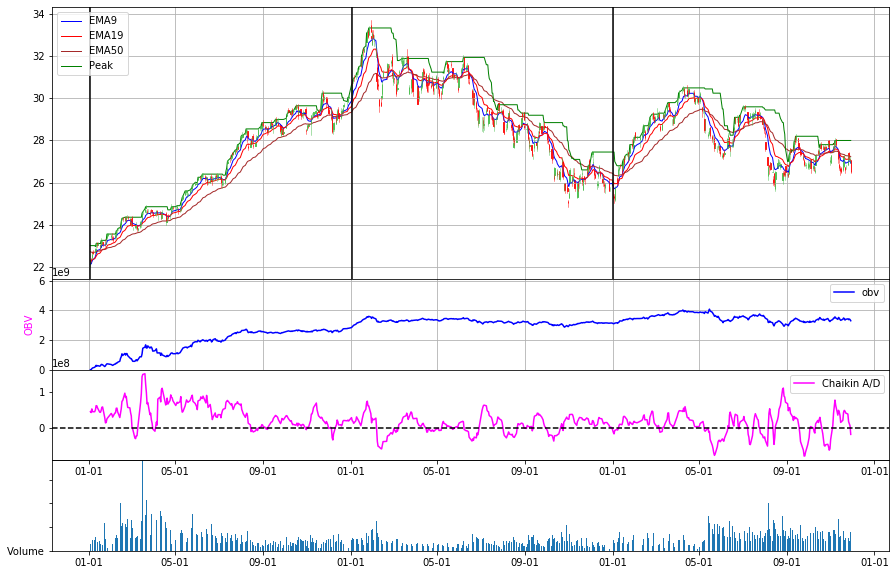

In [6]:
candlestick_gen1(L1,OHLC.loc[start:end],start,end,None,None,None,"fig3.png")

In [7]:
data1=data.loc[start:end].copy()

# Backtesting

In [8]:
def cross_over_up(param):
    df,TA1,TA2=param
    condition = (df[TA1]>df[TA2])
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_up_2pairs(param):
    df,TA1,TA2,TA3,TA4=param
    condition = (df[TA1]>df[TA2]) & (df[TA3]>df[TA4])
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_up1(param):
    df,TA1,TA2,TA3 = param
    TA1_TA2=np.where((df[TA1]>df[TA2]) & (df[TA2]>df[TA3]),1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_up2(param):
    df,TA1,TA2,TA3,TA4,TA5 = param
    condition = (df[TA1]>df[TA2]) & (df[TA3]>df[TA4]) & (df[TA4]>df[TA5])
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_up_doji_2(param):
    df,TA1,TA2 = param
    df_doji=TA.CDLDOJI(df["Open"], df["High"], df["Low"], df["Close"])
    condition = (df[TA1]>df[TA2]) & (df_doji > 0)
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_up_doji_morning_2(param):
    df,TA1,TA2 = param
    df_doji=TA.CDLDOJI(df["Open"], df["High"], df["Low"], df["Close"])
    df_morning=TA.CDLMORNINGDOJISTAR(df["Open"], df["High"], df["Low"], df["Close"])
    condition = (df[TA1]>df[TA2]) & ((df_doji > 0) | (df_morning > 0))
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_up_doji_morning_4(param):
    df,TA1,TA2,TA3,TA4 = param
    df_doji=TA.CDLDOJI(df["Open"], df["High"], df["Low"], df["Close"])
    df_morning=TA.CDLMORNINGDOJISTAR(df["Open"], df["High"], df["Low"], df["Close"])
    condition = (df[TA1]>df[TA2]) & (df[TA3]>df[TA4]) & ((df_doji > 0) | (df_morning > 0))
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_up_doji_3(param):
    df,TA1,TA2,TA3 = param
    df_doji=TA.CDLDOJI(df["Open"], df["High"], df["Low"], df["Close"])
    condition = (df[TA1]>df[TA2]) & (df[TA2]>df[TA3]) & (df_doji > 0)
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_up4(param):
    df,TA1,TA2,TA3,TA4,TA5 = param
    condition = (df[TA1]>df[TA2]) & (df[TA2]>df[TA3]) & (df[TA4]<df[TA5])
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_up_BBmid_RSI(param):
    df,TA1,TA2,TA3,TA4,TA5,TA6,TA7,TA8 = param
    # Close and High > BBmid + RSI > 50 + OBV-SMA9 > OBV-SMA19
    condition = (df[TA1]>df[TA3]) & (df[TA2]>df[TA3]) & (df[TA4]>50) & (df[TA4]<70) & (df[TA6]>df[TA7]) & (df[TA7]>df[TA8])
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_up_BBmid_RSI1(param):
    df,TA1,TA2,TA3,TA4,TA5,TA6,TA7,TA8,TA9,TA10 = param 
    # Close and High > BBmid + RSI < 50 + RSI9-9 > RSI9-19 > RSI9-50 
    # OBV-SMA9 > OBV-SMA19 > OBV-SMA50
    condition = (df[TA1]>df[TA3]) & (df[TA2]>df[TA3]) & \
                (df[TA5]>df[TA6]) & (df[TA6]>df[TA7]) & \
                (df[TA8]>df[TA9]) & (df[TA9]>df[TA10])
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

In [9]:
def cross_over_down(param):
    df,TA1,TA2 = param
    TA1_TA2=np.where((df[TA1]-df[TA2])<0,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

In [10]:
def stoploss(df,enter,threshold,long):
    Stop_loss_threshold=np.where((enter==1),df["Open"]*threshold,0)
    Stop_loss_threshold.replace(to_replace=0, method='ffill',inplace=True)
    if long==1:
        stop_loss=np.where((stop_loss_threshold>=df["Close"]),1,0)
    else:
        stop_loss=np.where((stop_loss_threshold<=df["Close"]),1,0)
    return(stop_loss)       
    

In [11]:
def strategy(df,enter,exit1,long,stoploss=None):
    buy_date=[]
    sell_date=[]
    price_buy=[]
    price_sell=[]
    #
    if stoploss is not None:
        exit2=(exit1) | (stoploss)
        exit=np.where(exit2 is True,1,0)
    else:
        exit=exit1
    #
    last_sell = datetime.strptime('01-01-1900', '%m-%d-%Y')
    #
    for i in enter.index[enter==1]:
        try:
            date1=df.index[df.index>i][0]
        except:
            break
        
        if date1 is not None:
            try:
                test=exit[exit==1]
                test1=test[test.index>=date1].index[0]
                test2=df.index[df.index>test1][0]
            except:
                test2=None
        else:
            test2=None
        if i > last_sell:
            buy_date.append(date1)
            sell_date.append(test2)
            if test2 is None:
                # since the no more exit, set last_sell to today to prevent any more enter
                last_sell = datetime.today()
            else:
                last_sell = test1
        
    for i in buy_date:
        if i is not None:
            price=df.loc[i]["Open"]
            price_buy.append(price)
        else:
            price_buy.append(None)
        
    
    for i in sell_date:
        if i is not None:
            price=df.loc[i]["Open"]
            price_sell.append(price)
        else:
            price_sell.append(None)
        
    d1=pd.DataFrame({"Date_Buy":buy_date,
                    "Date_Sell":sell_date,
                    "Price_Buy":price_buy,
                    "Price_Sell":price_sell})   
    if long==1:
        d1["Gain"]=d1["Price_Sell"]-d1["Price_Buy"]
        d1["Return"]=100*(d1["Price_Sell"]-d1["Price_Buy"])/d1["Price_Buy"]
        d1["Position"]="long"
    else:
        d1["Gain"]=d1["Price_Buy"]-d1["Price_Sell"]
        d1["Return"]=100*(d1["Price_Buy"]-d1["Price_Sell"])/d1["Price_Buy"]
        d1["Position"]="short"
    d1.index=d1["Date_Buy"]
    return(d1)

## EMA cross over strategy

In [12]:
# param = (data1,"macd","macdsignal")
# enter=cross_over_up(param)
param = (data1,"EMA5","BBmid")
enter=cross_over_up(param)
# param = (data1,"EMA5","BBmid","EMA9","EMA50")
# enter=cross_over_up_2pairs(param)
# param = (data1,"obv9","obv19","obv50")
# enter=cross_over_up1(param)
# param=(data1,"EMA9","EMA19","EMA50")
# enter=cross_over_up1(param)
# param = (data1,"macd","macdsignal","EMA9","EMA19","EMA50")
# enter=cross_over_up2(param)
# param = (data1,"EMA5","BBmid")
# enter=cross_over_up_doji_2(param)
# param = (data1,"EMA5","BBmid")
# enter=cross_over_up_doji_morning_2(param)
# param = (data1,"EMA5","BBmid","EMA9","EMA50")
# enter=cross_over_up_doji_morning_4(param)
# param = (data1,"EMA9","EMA19","EMA50")
# enter=cross_over_up_doji_3(param)
# param = data1,"EMA9","EMA19","EMA50","RSI9","RSI9-75"
# enter=cross_over_up4(param)
# param = (data1,'Close','High','BBmid','RSI9','RSI9-75','obv9','obv19','obv50')
# enter=cross_over_up_BBmid_RSI(param)
# Close and High > BBmid + RSI > 50 + OBV-SMA9 > OBV-SMA19
# param = (data1,'Close','High','BBmid','RSI9','RSI9-9','RSI9-19','RSI9-50','obv9','obv19','obv50')
# enter=cross_over_up_BBmid_RSI1(param)
    # Close and High > BBmid + RSI < 50 + RSI9-9 > RSI9-19 > RSI9-50 
    # OBV-SMA9 > OBV-SMA19 > OBV-SMA50

param = (data1,"EMA9","EMA19")
exit=cross_over_down(param)
param = (data1,"Low","BBlower")
exit1=cross_over_down(param)

### Display enter and exit

In [13]:
print(enter[enter==1].index.astype(str))
print(exit[exit==1].index.astype(str))

Index(['2017-01-19', '2017-01-26', '2017-02-07', '2017-02-15', '2017-03-06',
       '2017-03-29', '2017-04-05', '2017-04-12', '2017-04-21', '2017-05-09',
       '2017-05-23', '2017-06-02', '2017-06-19', '2017-06-26', '2017-07-10',
       '2017-07-27', '2017-07-31', '2017-08-16', '2017-08-22', '2017-09-08',
       '2017-09-18', '2017-09-28', '2017-10-16', '2017-10-25', '2017-10-27',
       '2017-11-03', '2017-11-20', '2017-12-08', '2017-12-20', '2018-01-16',
       '2018-01-23', '2018-02-12', '2018-03-08', '2018-03-27', '2018-04-06',
       '2018-04-19', '2018-04-30', '2018-05-08', '2018-05-21', '2018-05-29',
       '2018-06-01', '2018-06-22', '2018-06-29', '2018-07-09', '2018-07-23',
       '2018-08-07', '2018-08-20', '2018-08-27', '2018-09-11', '2018-09-20',
       '2018-10-10', '2018-10-12', '2018-10-30', '2018-11-01', '2018-11-15',
       '2018-11-26', '2018-12-03', '2018-12-12', '2018-12-24', '2018-12-31',
       '2019-01-04', '2019-01-18', '2019-01-25', '2019-02-01', '2019-02-12',

### Test a ENTER strategy with additional stringent criteria 

In [14]:
enter1 = (enter==1) & (data1['EMA9']>data1['EMA50'])
enter1[enter1==1].index.astype(str)

Index(['2017-01-19', '2017-01-26', '2017-02-07', '2017-02-15', '2017-03-06',
       '2017-03-29', '2017-04-05', '2017-04-12', '2017-04-21', '2017-05-09',
       '2017-05-23', '2017-06-02', '2017-06-19', '2017-06-26', '2017-07-10',
       '2017-07-27', '2017-07-31', '2017-08-16', '2017-08-22', '2017-09-08',
       '2017-09-18', '2017-09-28', '2017-10-16', '2017-10-25', '2017-10-27',
       '2017-11-03', '2017-11-20', '2017-12-20', '2018-01-16', '2018-01-23',
       '2018-03-27', '2018-05-21', '2018-05-29', '2018-06-01', '2019-01-18',
       '2019-01-25', '2019-02-01', '2019-02-12', '2019-02-20', '2019-03-04',
       '2019-03-12', '2019-03-28', '2019-04-16', '2019-04-29', '2019-06-28',
       '2019-07-11', '2019-07-25', '2019-09-13', '2019-10-28', '2019-11-04'],
      dtype='object')

In [15]:
# exit1[exit1==1].index.astype(str).tolist()
exit2=(exit[exit==1]) | (exit1[exit1==1])

In [16]:
df=strategy(data1,enter,exit,1)
df.style.format({
    'Return': '{:,.2%}'.format
})
df

,Date_Buy,Date_Sell,Price_Buy,Price_Sell,Gain,Return,Position
Date_Buy,,,,,,,
2017-01-20,2017-01-20,2017-04-20,23.150000,24.100000,0.950001,4.103675,long
2017-04-24,2017-04-24,2017-09-29,24.450001,28.350000,3.900000,15.950918,long
2017-10-17,2017-10-17,2017-11-01,29.700001,28.500000,-1.200001,-4.040407,long
2017-11-06,2017-11-06,2017-12-06,28.799999,29.049999,0.250000,0.868056,long
2017-12-11,2017-12-11,2018-02-08,28.799999,30.700001,1.900002,6.597228,long
2018-02-13,2018-02-13,2018-03-27,30.000000,31.250000,1.250000,4.166667,long
2018-03-28,2018-03-28,2018-05-31,31.100000,30.549999,-0.550001,-1.768492,long
2018-06-04,2018-06-04,2018-06-19,31.200001,30.400000,-0.800001,-2.564106,long
2018-06-25,2018-06-25,2018-09-06,29.850000,28.000000,-1.850000,-6.197656,long


### Display signal in the buy date

In [17]:
pd.options.display.float_format = '{:.2f}'.format
data1.loc[df.index, ['EMA9', 'EMA50']]
# data1.loc[df.index, ['RSI9']]

,EMA9,EMA50
Date_Buy,,
2017-01-20,23.02,22.81
2017-04-24,24.39,24.19
2017-10-17,29.36,28.58
2017-11-06,28.91,28.78
2017-12-11,29.07,29.14
2018-02-13,30.79,30.98
2018-03-28,31.08,31.18
2018-06-04,31.05,30.98
2018-06-25,30.26,30.87


In [18]:
buy_list=df.index.tolist()

In [19]:
sell_list=df["Date_Sell"].tolist()

In [20]:
#sell_list=df["Date_Sell"].dt.strftime("%Y-%m-%d").tolist()

### Calculate GAIN

In [21]:
df_sum=df.copy()

In [22]:
GAIN=[]
for i in data1.index:
    if i in list(df_sum.index):
        result=df_sum.loc[i]["Gain"]
    else:
        result=0
    GAIN.append(result)
GAIN_df=pd.Series(GAIN,index=data1.index)     

In [23]:
GAIN_df.dropna().cumsum()[-1]

7.5

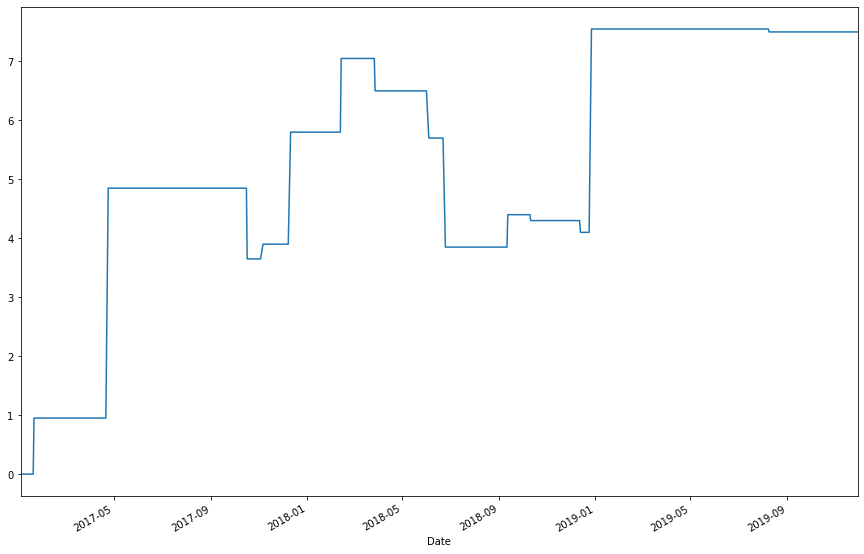

In [24]:
GAIN_df.dropna().cumsum().plot(figsize=(15,10))

### Define Start and End date

In [27]:
start_chart=start
end_chart=end

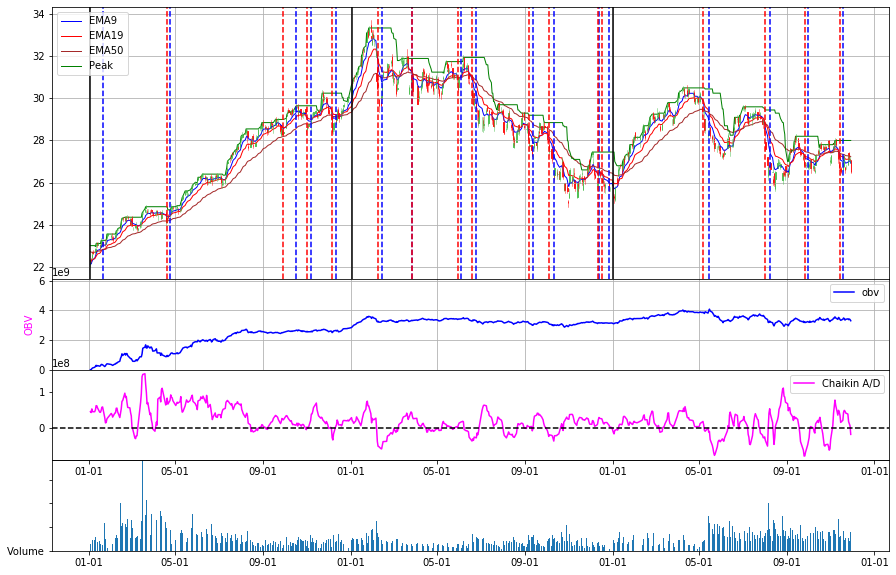

In [28]:
candlestick_gen1(L1,OHLC.loc[start:end],start_chart,end_chart,data.loc[start:end],buy_list,sell_list,"fig1.png")

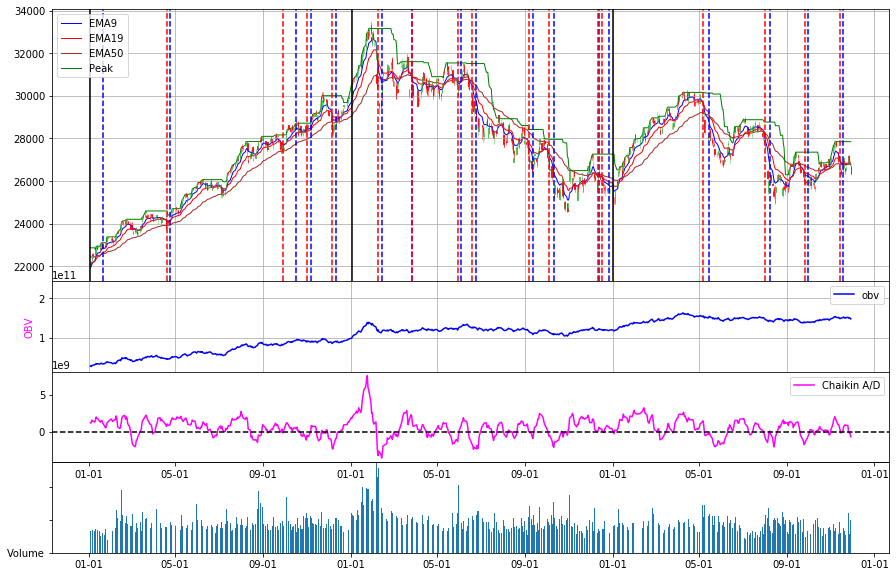

In [29]:
candlestick_gen1('^HSI',OHLC_HSI.loc[start:end],start_chart,end_chart,data_HSI.loc[start:end],buy_list,sell_list,"fig1a.png")

### Compare each algorithm

In [30]:
functions_dict = {
    'cross_over_up_macd' : cross_over_up,
    'cross_over_up_BB' : cross_over_up,
    'cross_over_up1_obv' : cross_over_up1,
    'cross_over_up1_EMA' : cross_over_up1,
    'cross_over_up2' : cross_over_up2,
    'cross_over_up_doji_2' : cross_over_up_doji_2,
    'cross_over_up_doji_morning_2' : cross_over_up_doji_morning_2,
    'cross_over_up_doji_3' : cross_over_up_doji_3,
    'cross_over_up4' : cross_over_up4,
    'cross_over_up_BBmid_RSI' : cross_over_up_BBmid_RSI,
    'cross_over_up_BBmid_RSI1' : cross_over_up_BBmid_RSI1,
}
params_dict = {
    'cross_over_up_macd' : (data1,"macd","macdsignal"),
    'cross_over_up_BB' : (data1,"EMA5","BBmid"),
    'cross_over_up1_obv' : (data1,"obv9","obv19","obv50"),
    'cross_over_up1_EMA' : (data1,"EMA9","EMA19","EMA50"),
    'cross_over_up2' : (data1,"macd","macdsignal","EMA9","EMA19","EMA50"),
    'cross_over_up_doji_2' : (data1,"EMA5","BBmid"),
    'cross_over_up_doji_morning_2' : (data1,"EMA5","BBmid"),
    'cross_over_up_doji_3' : (data1,"EMA9","EMA19","EMA50"),
    'cross_over_up4' : (data1,"EMA9","EMA19","EMA50","RSI9","RSI9-75"),
    'cross_over_up_BBmid_RSI' : (data1,'Close','High','BBmid','RSI9','RSI9-75','obv9','obv19','obv50'),
    'cross_over_up_BBmid_RSI1' : (data1,'Close','High','BBmid','RSI9','RSI9-9','RSI9-19','RSI9-50','obv9','obv19','obv50'),
}
kpi = dict()
for k, func in functions_dict.items():
    enter_cp = func(params_dict[k])
    param = (data1,"EMA9","EMA19")
    exit_cp = cross_over_down(param)
    df_cp = strategy(data1,enter_cp,exit_cp,1)
    #
    GAIN=[]
    for i in data1.index:
        if i in list(df_cp.index):
            result=df_cp.loc[i]["Gain"]
        else:
            result=0
        GAIN.append(result)
    GAIN_df=pd.Series(GAIN,index=data1.index)
    kpi[k] = GAIN_df.dropna().cumsum()[-1]

In [31]:
for algo in sorted(kpi, key=kpi.get, reverse=True):
    print('{} : {:.2f}'.format(algo, kpi[algo]))

cross_over_up_doji_2 : 9.65
cross_over_up_doji_morning_2 : 9.65
cross_over_up_BB : 7.50
cross_over_up1_obv : 4.75
cross_over_up_BBmid_RSI : 2.95
cross_over_up_doji_3 : 2.60
cross_over_up1_EMA : 2.35
cross_over_up2 : 2.05
cross_over_up4 : 1.70
cross_over_up_BBmid_RSI1 : 1.65
cross_over_up_macd : 1.50


### Test getattr

In [32]:
functions_dict = {'cross_over_up1': cross_over_up1}
params_dict = {'cross_over_up1': (data1,"EMA9","EMA19","EMA50")}

mystring = 'cross_over_up1'
if mystring in functions_dict:
    print(functions_dict[mystring](params_dict[mystring]))
    

2017-01-03    0
2017-01-04    0
2017-01-05    0
2017-01-06    0
2017-01-09    0
2017-01-10    0
2017-01-11    0
2017-01-12    0
2017-01-13    0
2017-01-16    0
2017-01-17    0
2017-01-18    0
2017-01-19    0
2017-01-20    1
2017-01-23    0
2017-01-24    0
2017-01-25    0
2017-01-26    0
2017-01-27    0
2017-02-01    0
2017-02-02    0
2017-02-03    0
2017-02-06    0
2017-02-07    0
2017-02-08    0
2017-02-09    0
2017-02-10    0
2017-02-13    0
2017-02-14    0
2017-02-15    0
             ..
2019-10-21    0
2019-10-22    0
2019-10-23    0
2019-10-24    0
2019-10-25    1
2019-10-28    0
2019-10-29    0
2019-10-30    0
2019-10-31    0
2019-11-01    0
2019-11-04    0
2019-11-05    0
2019-11-06    0
2019-11-07    0
2019-11-08    0
2019-11-11    0
2019-11-12    0
2019-11-13    0
2019-11-14    0
2019-11-15    0
2019-11-18    0
2019-11-19    0
2019-11-20    0
2019-11-21    0
2019-11-22    0
2019-11-25    0
2019-11-26    0
2019-11-27    0
2019-11-28    0
2019-11-29    0
Length: 718, dtype: int6